# HW 2: Car wash simulation

You've been contracted to write a simulation to help a local car wash with their
business plan. The machine they operate for the automated car wash has various
settings that affect the speed with which a car is washed and the amount of
water and soap that are consumed. The company wants to know how many customers
they can serve and how long they will have to wait in line.

The program specifications are as follows. The program has three input items:
1. The amount of time it takes to wash one car, in seconds
2. The probability that a new customer arrives during any given second
3. The total length of time to be simulated, in seconds

The program produces two outputs, based on its computations:
1. The number of customers served during the simulation time
2. The average waiting time for customers during the simulation, in seconds

In this assignment, you'll use a queue (and a few other objects) to manage the
simulation. The printer queue example in Miller and Ranum is an instructive
example. There are many comments and I have tried to make the instructions
detailed and clear. Please read carefully, and then *ask* if you are stuck!

There is a chat button in the top right of the Cocalc window (speech bubbles).
If you use it, I will see your message and respond.

### The queue of customers

All we really need to know about the customers is how long they wait in the
queue. So, when one arrives, we will represent them by a number called a
*timestamp*. The simulation works in seconds, so the timestamp will just be the
number of seconds that have already passed during the simulation before the
customer arrives. When a customer is removed from the queue (their car is
washed), we can then calculate the number of seconds they waited.

You'll use the `deque` object from Python's standard module `collections`.
There's no need to wrap it in a custom `Queue` class. If you restrict yourself
to using methods `deque.appendleft()` and `deque.pop()` then your deque is
functioning as a queue. Note that the `deque` class lacks our `.is_empty()`
method from class. Instead use `len()` just as you would for a list. (Puzzle:
how could we add this functionality to our homebrew `Queue` class?)

In [1]:
from collections import deque

### The `washer` object

Instances of the `washer` class simulate the machine that washes cars. Its
constructor will take one parameter (in addition to `self`): the number of
seconds needed to wash a car, `wash_time`. When the washer starts washing,
sets its `time_until_done` attribute equal to `wash_time`.

Each time another second passes, the simulation program will indicate the
passage of one second for the washer. This is done by the instance method
`washer.one_second()`.

The washer needs to be able to tell the rest of the program whether it is
currently busy, and to start washing the next car in the queue. These are
done via member functions `washer.is_busy()` and `washer.wash()`.

In [2]:
class Washer:
    """The washer knows whether it is washing, and if it is, how long it will be until the
    next car can exit the waiting queue.
    """
    def __init__(self, wash_time):
        """Sets up a Washer instance. Make sure you know what the instance attributes should be!"""
        # YOUR CODE HERE
        self.wash_time = wash_time
        self.time_until_done = 0

    def is_busy(self):
        """Return True if the washer is currently washing (so no car can
        exit the queue yet) and False if not (the next car can be dequeued)."""
        # YOUR CODE HERE
        if self.time_until_done != 0:
            return True
        else:
            return False

    def start_washing(self):
        """Tell the washer to wash the car at the front of the
        queue by updating its attributes appropriately."""
        # YOUR CODE HERE
        if self.is_busy() == False:
            self.time_until_done = self.wash_time

    def one_second(self):
        """Update the washer's attributes to reflect the passage of one second."""
        # YOUR CODE HERE
        if self.time_until_done != 0:
            self.time_until_done = self.time_until_done - 1

In [3]:
# Check that the Washer class does what it is supposed to:
from nose.tools import assert_equal
w = Washer(100)
assert_equal(w.wash_time, 100)
assert_equal(w.time_until_done, 0)
for key in vars(w):
    assert(key in ('wash_time', 'time_until_done'))

w.time_until_done = 1
assert(w.is_busy())
w.time_until_done = 0
assert(not w.is_busy())

w.start_washing()
assert_equal(w.time_until_done, w.wash_time)

w.time_until_done = 10
w.one_second()
assert_equal(w.time_until_done, 9)

### Managing arrivals

We'll use the probability input to determine, during each simulated second,
whether or not a new customer arrives at the rear of the queue. This could be
done with a simple free-standing (i.e., not an instance method) function, but
the design choice here is to use a single instance of a custom class, called
`ArrivalGenerator`. The `ArrivalGenerator` class has a constructor that takes
one optional argument, the probability input of the program. (If no argument is
passed, the constructor uses the default value of `0.5`.) It has a single
instance method `ArrivalGenerator.query()` that returns either `True` or
`False`, with `True` occurring with probability given by the constructor's
argument. We'll use some helper functions from the `random` module to generate
these random occurrences.

In [4]:
import random

class ArrivalGenerator:
    def __init__(self, prob=0.5):
        """The ArrivalGenerator has one job: return True with probability `prob`.
        To do that, it needs to save the value of `prob`.
        """
        # YOUR CODE HERE
        self.probability = prob

    def query(self):
        """Return True with probability prob. There are many different ways 
        you might use the `random` module's functions
        to do it. If you want a hint, please ask, I don't want you to get hung up on the
        math of probability too much."""
        # YOUR CODE HERE
        while self.probability >= random.random():
            return True


In [5]:
# Check that ArrivalGenerator does what it is supposed to do:
from nose.tools import assert_equal
a = ArrivalGenerator()
assert_equal(a.probability, 0.5)
a = ArrivalGenerator(0.9)
assert_equal(a.probability, 0.9)

arrivals_list = (a.query() for _ in range(1_000_000))
number_of_arrivals = sum([1 for x in arrivals_list if x])
# You should get something very close to 900000
assert(899000 < number_of_arrivals and number_of_arrivals < 901000)
# If it fails, but you think you are right, just try again. It is probabilistic,
# so could be false negative. But two false negatives is unlikely to happen.

### Tracking the average waiting time

To track the average waiting time, we'll use another custom class instance.
The class is called `AverageTracker`. Its only job is to compute the
average of a sequence of numbers. For example, we could send the values
234, 234, 908, and 279 into an `AverageTracker`. It could then tell us
that the average of these values is 413.75. It could also tell us that
so far it has processed 4 values. Thus we can use our `AverageTracker`
to keep track of the average waiting time *and* the number of customers
served during the simulation.

The `AverageTracker` has a constructor that prepares the `AverageTracker`
instance to accept a sequence of numbers. The instance receives one value
at a time through instance method `AverageTracker.next_value()`.

There are two instance methods to obtain info from the `AverageTracker`.
These are `AverageTracker.number_of_values()` and `AverageTracker.average()`.

In [6]:
class AverageTracker:
    def __init__(self):
        """The average tracker just needs to know the total of all numbers
        it has received so far and how many numbers it's received."""
        # YOUR CODE HERE
        self.count = 0
        self.sum_ = 0

    def next_value(self, val):
        """This method adds `val` to the total received so far and increments
        the number of values received."""
        # YOUR CODE HERE
        self.sum_ += val
        self.count += 1

    def average(self):
        """Return the average of all the values so far."""
        # YOUR CODE HERE
        return self.sum_ / self.count

    def number_of_values(self):
        """Return the number of values received so far."""
        # YOUR CODE HERE
        return self.count

In [7]:
from nose.tools import assert_equal
import random
at = AverageTracker()
assert_equal(at.count, 0)
assert_equal(at.sum_, 0)
for key in vars(at):
    assert(key in ('count', 'sum_'))

at = AverageTracker()
random_value_list = [random.random() for _ in range(1000)]
for val in random_value_list:
    at.next_value(val)

assert_equal(at.count, len(random_value_list))
assert_equal(at.sum_, sum(random_value_list))
assert(at.average() == sum(random_value_list)/len(random_value_list))

### Pseudocode for main program

<ol style="list-style-type: upper-roman">
    <li>Initialize the input values for the program. These are arrival probability and simulation time.</li>
    <li>Initialize a <tt>Washer</tt> instance, making sure to supply a value for its parameter (how long it takes to wash a car).</li>
    <li>Initialize instances of <tt>ArrivalGenerator</tt>, <tt>AverageTracker</tt>, and <tt>deque</tt>.</li>
    <li>For each integer between 0 and the simulation time:</li>
    <ol style="list-style-type: upper-alpha">
        <li>Ask the <tt>ArrivalGenerator</tt> whether a new customer arrives during the current second. If so, enqueue the value of the current second.</li>
        <li>If the <tt>Washer</tt> is not busy and the queue is not empty:</li>
        <ol style="list-style-type: arabic">
            <li>Remove the next value from the queue. This is the arrival timestamp of the car about to get washed.</li>
            <li>Compute how long the next car had to wait, and send that value to the <tt>AverageTracker</tt>.</li>
            <li>Tell the <tt>Washer</tt> to start washing the next car in line.</li>
        </ol>
            <li>Tell the <tt>Washer</tt> another second has passed. (This is how the washer knows when it is no longer busy.)</li>
    </ol>
    <li>Now the simulation is done. Print a report including the simulation time and probability, number of cars washed, and average waiting time. Example:<br/>
        <tt>Simulation complete<br/>
        In 1000 seconds with probability 0.005: washed 23 cars with average waiting time 83.2 seconds.
        </tt>
    </li>
</ol>

### Read this carefully

Make sure you don't reinvent the wheel. A fully object-oriented, encapsulated style means that your main program does less work on its own. In this program, it should mostly coordinate the actions of various objects, who handle the details of the simulation as you've already written them. It does this by passing messages (values) between them. Set your objects up, then let them do their work.

### Testing your simulation

You should get realistic values with the probability, simulation time, and wash time that are provided.

In [8]:
from collections import deque

prob = 0.004
simulation_time = 6000
wash_time = 150

# YOUR CODE HERE
def simulation(prob, simulation_time, wash_time):
    ws = Washer(wash_time)
    arg = ArrivalGenerator(prob)
    avg_wash_time = AverageTracker()
    wash_deque = deque()
    for current_second in range(simulation_time):
        if arg.query() == True:
            wash_deque.appendleft(current_second)
        if ws.is_busy() == False and len(wash_deque) != 0:
            timestamp = wash_deque.pop()
            avg_wash_time.next_value(current_second - timestamp)
            ws.start_washing()
        ws.one_second()
    avg_time = avg_wash_time.average()
    count = avg_wash_time.number_of_values()
    print(f"In {simulation_time} seconds with probability {prob}: washed {count} cars with average waiting time {avg_time} seconds.")
    return count, avg_time

### SIMULATE

Run your simulation ten thousand times (it will take a minute or two). Store the
results in two lists. Each run of the simulation produces a count and an
average. After each run, capture these values. Append the count to the list of
counts and the average to the list of averages. Return the two lists at once,
like this:

```python
return counts, averages
```

In [9]:
def ten_thousand_runs():
    """
    Get lists of ten thousand counts and averages from the simulator.
    Return the lists like this:
    return counts, averages
    """
    # YOUR CODE HERE
    counts = []
    averages = []
    for _ in range(10000):
        count, avg_time = simulation(0.004, 6000, 150)
        counts.append(count)
        averages.append(avg_time)
    return counts, averages

counts, averages = ten_thousand_runs()

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 187.07142857142858 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 293.6969696969697 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 176.26666666666668 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 77.46153846153847 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 124.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 80.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 397.4 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 55.18181818181818 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 127.92857142857143 seconds.
In 6000 seconds with probability 0.00


In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 78.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 469.84375 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 104.6 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 57.1578947368421 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 32.31578947368421 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 128.25806451612902 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 52.12 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 62.40909090909091 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 226.47826086956522 seconds.
In 6000 seconds with probability 0.004: washed 20 cars wit

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 54.52 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 35.17391304347826 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 42.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 255.96774193548387 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 75.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 72.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 23.894736842105264 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 328.5483870967742 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 50.833333333333336 seconds.
In 6000 seconds with probability 0.0

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 56.17391304347826 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 61.09090909090909 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 111.8 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 25.176470588235293 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 284.85714285714283 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 38.7 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 150.20689655172413 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 78.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 62.526315789473685 seconds.
In 6000 seconds with probability 0.004: washed 32

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 57.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 59.16 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 136.2 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 77.41666666666667 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 79.5925925925926 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 59.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 272.90909090909093 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 138.72413793103448 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 47.5 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting 

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 38.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 140.69565217391303 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 173.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 84.51851851851852 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 99.79166666666667 seconds.
In 6000 seconds with probability 0.004: washed 35 cars with average waiting time 245.82857142857142 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 157.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 62.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 25.235294117647058 seconds.
In 6000 seconds with pr

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 40.22222222222222 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 109.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 96.61538461538461 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 46.75 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 24.4375 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 102.26923076923077 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 165.62962962962962 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 69.18181818181819 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 71.64 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 69.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.0 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 161.36666666666667 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 243.96428571428572 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 114.53846153846153 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 93.32 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 49.1 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 128.89655172413794 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 136.93333333333334 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with a

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 250.96 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 86.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 112.61538461538461 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 29.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 75.96 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 247.48387096774192 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 66.2 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 156.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 122.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 78.82

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 125.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 97.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 88.10526315789474 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 96.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 87.18181818181819 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 84.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 73.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 66.6 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 26.36842105263158 seconds.
In 6000 seconds with probability 0.004: w

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 29.545454545454547 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 180.89655172413794 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 93.5 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 86.76 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 73.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 241.03846153846155 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 97.54166666666667 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 107.20833333333333 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 64.03703703703704 seconds.
In 6000 seconds with probability 0.004: washed 23

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 49.925925925925924 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 214.06451612903226 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 20.0 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 42.73684210526316 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 25.055555555555557 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 147.72413793103448 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 193.2962962962963 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 82.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 84.46428571428571 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 174.6086956521739 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 50.35 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 36.69230769230769 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 61.074074074074076 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 72.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 87.12 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 53.48 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 26.3 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 92.72 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 117.3333

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 209.3 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 69.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 57.916666666666664 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 134.28 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 149.36 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 77.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 29.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 29.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 71.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiti

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 98.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 35 cars with average waiting time 213.02857142857144 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 51.3 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 204.2 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 131.36 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 54.916666666666664 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 98.625 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 169.76923076923077 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average wait

In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 125.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 88.53333333333333 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 71.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 155.16666666666666 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 68.75 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 90.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 60.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 100.78571428571429 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 62.2962962962963 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 52.375 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 33.578947368421055 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 31.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 70.6842105263158 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 92.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 38.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 65.25 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 22.6875 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 125.5 seconds.
In 6000 seconds with probability 0.004: washed 12 cars with average wait

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 165.25 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 110.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 152.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 37.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 85.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 41.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 93.65217391304348 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting 

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 33.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 137.16666666666666 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 55.36 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 141.42307692307693 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 23.842105263157894 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 18.0 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 156.3548387096774 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 22.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 46.857142857142854 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with av

In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 28.533333333333335 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 208.55555555555554 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 62.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 116.44 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 57.791666666666664 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 81.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 53.2 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 90.68 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 146.13793103448276 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiti

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 191.32 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 149.93333333333334 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 144.32 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 35.75 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 52.81818181818182 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 36.391304347826086 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 69.5 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 198.35714285714286 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 152.4090909090909 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average wait

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 73.4 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 156.8 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 47.733333333333334 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 119.74074074074075 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 54.869565217391305 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 88.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 26.0 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 42.166666666666664 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with av

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 144.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 57.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 189.4375 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 182.75862068965517 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 97.7 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 99.45161290322581 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 40.43478260869565 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 216.38709677419354 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 118.82608695652173 seconds.
In 6000 seconds with probability 0.004: washed

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 51.791666666666664 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 33.94444444444444 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 82.62962962962963 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 70.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 80.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 64.79166666666667 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 106.26666666666667 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 34.611111111111114 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 35.421052631578945 seconds.
In 6000 seconds with pro

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 150.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 148.44 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 86.37931034482759 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 220.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 181.72727272727272 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 61.611111111111114 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 158.64 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 162.67857142857142 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 207.5 seconds.
In 6000 seconds with probability 0.004: washed 25 cars wi


In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 111.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 124.3030303030303 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 54.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 102.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 59.708333333333336 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 34.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 88.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 114.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 67.6086956521739 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 82.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 17.3 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 92.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 74.8 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 302.6666666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 212.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 150.78125 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 51.65384615384615 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 152.53333333333333 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with 

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 45.44 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 220.92 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 42.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.04166666666667 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 62.1 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 73.63157894736842 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 158.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 15.764705882352942 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 51.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with av

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 110.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 26.647058823529413 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 71.47619047619048 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 76.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 60.69565217391305 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 22.647058823529413 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 111.84 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 33.65217391304348 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 74.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 19

In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 4.6875 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 93.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 12 cars with average waiting time 29.5 seconds.
In 6000 seconds with probability 0.004: washed 36 cars with average waiting time 148.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 77.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 71.95833333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 149.33333333333334 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 111.76666666666667 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 71.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 21 

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 70.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 43.72222222222222 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 84.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 107.2 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 148.95833333333334 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 71.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 44.3 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 69.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 34.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 22 car

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 169.19230769230768 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 50.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 57.421052631578945 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 57.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 11 cars with average waiting time 29.363636363636363 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 142.875 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 138.0344827586207 seconds.
In 6000 seconds with probability 0.004: washed 36 cars with average waiting time 317.3611111111111 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 210.08823529411765 seconds.
In 6000 seconds with probability 

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 140.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 51.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 65.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 46.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 95.52631578947368 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 86.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 105.16666666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 134.42857142857142 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 53.59090909090909 seconds.
In 6000 seconds with pro

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 74.64 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 37.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 43.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 113.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 79.07692307692308 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 84.6 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 139.43333333333334 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 69.96875 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 62.43478260869565 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiti


In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 57.4 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 56.1 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 41.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 108.03571428571429 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 99.76 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 36.11764705882353 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 32.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 24.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 61.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with ave

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.54545454545455 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 69.0 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 68.25 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 129.9047619047619 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 90.1 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 20.6 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 143.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 115.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 69.8 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 49.2 seco

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 24.88235294117647 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 37.05882352941177 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 107.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 178.3846153846154 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 111.84 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 69.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 41.53333333333333 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 100.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 120.2 seconds.
In 6000 seconds with probability 0.004: washed 27

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 65.52631578947368 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 74.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 44.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 37.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 38.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 72.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 92.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 27.5 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 16.82608695652174 seconds.
In 6000 seconds with probability 0.004: washed 12 cars

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 238.78125 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 64.4 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 59.64705882352941 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 115.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 83.96428571428571 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 116.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 45.421052631578945 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 93.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 58.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 134.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 133.5 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 119.25 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 24.3125 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 25.88235294117647 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 30.333333333333332 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 92.54545454545455 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 76.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 60.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average wai

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 184.71875 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 39.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 86.36 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 321.1333333333333 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 92.42307692307692 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 85.27272727272727 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 312.80645161290323 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 52.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 114.04166666666667 seconds.
In 6000 seconds with probability 0.004: washe

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 41.57692307692308 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 37.53846153846154 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 85.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 40.833333333333336 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 83.36 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 108.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 145.92592592592592 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 58.77272727272727 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 70.5925925925926 seconds.
In 6000 seconds with probability 0.004


In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 56.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 68.16666666666667 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 116.9 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 43.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 80.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 160.59375 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 21.176470588235293 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 32.75 seconds.
In 6000 seconds with probability 0.004: washed 19 cars wi

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 228.43333333333334 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 88.70833333333333 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 126.8076923076923 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 186.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 86.3076923076923 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 39.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 33.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 38.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 79.76470588235294 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with averag


In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 124.32 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 112.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 93.77272727272727 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 34.388888888888886 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 58.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 56.65217391304348 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 72.125 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 80.31818181818181 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 48.76923076923077 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 96.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 119.16 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 262.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 126.4 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 163.7 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 81.9 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 122.88 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 87.86363636363636 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 91.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 79.96428571428571 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 79.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 75.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 50.578947368421055 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 57.78947368421053 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 35.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 115.65384615384616 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 118.96153846153847 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 181.82758620689654 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 39.77777777777778 seconds.
In 6000 seconds with prob

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 72.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 36.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 98.88 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 60.26315789473684 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 148.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 223.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 104.75 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 82.3076923076923 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 199.2962962962963 seconds.
In 6000 seconds with probability 0.004: washed 26 

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 47.35294117647059 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 60.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 101.03225806451613 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 175.74074074074073 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 26.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 64.17241379310344 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 193.87878787878788 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 171.6451612903226 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 16.75 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 84.08 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 73.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 180.90322580645162 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 88.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 69.46428571428571 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 120.92 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 116.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 143.42857142857142 seconds.
In 6000 seconds with probability 0.004: washed 11 cars with 

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 89.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 45.18181818181818 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 63.77272727272727 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 35.59090909090909 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 76.89473684210526 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 179.6875 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 113.6 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 204.3181818181818 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 143.70967741935485 seconds.
In 6000 seconds with probability 0.004: washed 2

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 58.833333333333336 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 47.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 108.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 21.4375 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 25.944444444444443 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 67.65 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 43.416666666666664 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 104.93333333333334 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 68.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 25.526315789473685 seconds.
In 6000 seconds with probability 0.004: washed 10 cars with average waiting time 6.7 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 56.57692307692308 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 62.63636363636363 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 72.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 90.44827586206897 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 69.96666666666667 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 103.18181818181819 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 138.375 seconds.
In 6000 seconds with probability 0.004: washed 29 

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 39.21052631578947 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 53.68181818181818 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 24.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 10.642857142857142 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 116.45833333333333 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 161.57142857142858 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 59.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 83.5 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 82.37037037037037 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 108.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 70.05 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 72.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 36 cars with average waiting time 232.94444444444446 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 47.391304347826086 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 88.03846153846153 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 31.4 seconds.
In 6000 seconds with probability 0.004: washed 36 cars with average waiting time 241.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 76.55 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waitin

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 39.17857142857143 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 90.9047619047619 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 17.157894736842106 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 9.105263157894736 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 72.95833333333333 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 115.2 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 27.6 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 75.25925925925925 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 43.64705882352941 seconds.
In 6000 seconds with probability 0.004: washed 25 car

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 90.52631578947368 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 119.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 52.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 89.74074074074075 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 78.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 87.32 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 77.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 38.888888888888886 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 86.33333333333333 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 60.78947368421053 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 100.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 66.69565217391305 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 26.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 72.10714285714286 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 245.36363636363637 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 548.6060606060606 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 54.166666666666664 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 78.15 seconds.
In 6000 seconds with probability 0.0


In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 59.69230769230769 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 110.18518518518519 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 101.1 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 101.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 101.375 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 54.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 64.26666666666667 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 183.26666666666668 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 65.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 80.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 125.3076923076923 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 66.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 46.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 92.44 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 136.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 45.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 64.69565217391305 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 35.05882352941177 seconds.
In 6000 seconds with probability 0.004: washed 23 car

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 178.92857142857142 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 17.529411764705884 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 35.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 34.26315789473684 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 88.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 93.04347826086956 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 64.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 110.67857142857143 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 92.95833333333333 seconds.
In 6000 seconds with prob

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 139.9 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 60.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 56.904761904761905 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 69.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 53.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 56.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 42.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 167.78571428571428 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 30.235294117647058 seconds.
In 6000 seconds with probability 0.

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 77.14814814814815 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 24.666666666666668 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 73.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 35.8 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 55.791666666666664 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 154.33333333333334 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 47.21052631578947 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 189.83333333333334 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 36.666666666666664 seconds.
In 6000 seconds with probability 0.0

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 65.13333333333334 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 27.05263157894737 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 82.52631578947368 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 57.75 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 166.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 34.8 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 51.35 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 103.9047619047619 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 252.51724137931035 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with aver

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 69.1304347826087 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 91.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 94.0 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 20.68421052631579 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 20.095238095238095 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 92.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 161.33333333333334 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 29.772727272727273 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 81.29629629629629 seconds.
In 6000 seconds with probability 0.004: w


In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 37.8 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 21.94736842105263 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 81.84210526315789 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 64.08 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 53.7 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 31.17391304347826 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 79.1 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 129.6206896551724 seconds.


In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 83.53846153846153 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 94.48148148148148 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 105.625 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 73.61538461538461 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 117.0 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 164.3793103448276 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 64.43478260869566 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 90.92 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 111.62962962962963 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with a


In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 55.16 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 136.2 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 71.7 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 101.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 92.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 97.04166666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 98.5 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 41.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 60.52380

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 79.25 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 96.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 157.36666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 51.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 55.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 23.05 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 191.2 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 114.87096774193549 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 93.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with av

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 86.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 19.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 53.30769230769231 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 79.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 35.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 27.7 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 38.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 76.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 69.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 37 car

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 92.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 121.42424242424242 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 56.89473684210526 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 25.25 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 91.82608695652173 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 61.82608695652174 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 95.5 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 34.888888888888886 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 180.27272727272728 seconds.
In 6000 seconds with probability 0.004: washed 25 

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 113.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 101.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 122.24 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 209.4848484848485 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 44.0 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 152.48387096774192 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 151.3548387096774 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 44.24 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 75.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with a

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 90.95 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 63.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 66.94736842105263 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 71.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 67.63157894736842 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 95.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 106.41176470588235 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 191.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 35.095238095238095 seconds.
In 6000 seconds with probability 0.0

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 43.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 56.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 37.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 96.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 74.44 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 63.28 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 66.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 61.15 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 36.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with av

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 291.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 77.15384615384616 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 127.76666666666667 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 80.28 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 54.083333333333336 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 87.48148148148148 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 128.44444444444446 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 64.36363636363636 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 20.529411764705884 seconds.
In 6000 seconds with probability 0.004: washed 3

In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 24.066666666666666 seconds.
In 6000 seconds with probability 0.004: washed 38 cars with average waiting time 270.1842105263158 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 56.526315789473685 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 100.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 148.2962962962963 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 62.958333333333336 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 165.8181818181818 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 77.53333333333333 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 95.0909090909091 seconds.
In 6000 seconds with prob

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 32.11538461538461 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 64.76470588235294 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 45.407407407407405 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 32.05555555555556 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 68.41666666666667 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 79.61111111111111 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 54.3125 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 49.2 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 376.59375 seconds.
In 6000 seconds with probability 0.004: washed 21 cars wit

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 53.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 139.15 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 70.18181818181819 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 155.96428571428572 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 29.692307692307693 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 116.82758620689656 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 95.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 249.55172413793105 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 163.31034482758622 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 102.34482758620689 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 52.416666666666664 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 156.68 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 83.61538461538461 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 167.20833333333334 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 18.705882352941178 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 88.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 41.7 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 48.111111111111114 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 156.6 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 121.78571428571429 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 38.68181818181818 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 76.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 80.36363636363636 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 110.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 182.25 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 67.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 31.25 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with a

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 82.27586206896552 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 49.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 83.15384615384616 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 75.125 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 93.16666666666667 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 84.84 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 61.72222222222222 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 70.71428571428571 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 54.81818181818182 seconds.
In 6000 seconds with probability 0.004: washed 25 c

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 71.65384615384616 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 50.13636363636363 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 138.05555555555554 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 245.96774193548387 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 96.31818181818181 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 81.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 79.07692307692308 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 38.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 103.28 seconds.
In 6000 seconds with probability 0.004: washed 19 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 67.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 46.26315789473684 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 172.97058823529412 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 160.0 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 85.29629629629629 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 125.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 191.24137931034483 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 165.39285714285714 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 80.33333333333333 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 23.818181818181817 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 38.10526315789474 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 155.34782608695653 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 118.92592592592592 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 37.10526315789474 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 84.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 34.76470588235294 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 40.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 116.75862068965517 seconds.
In 6000 seconds with pr

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 141.4375 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 109.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 95.45833333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 83.125 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 10.055555555555555 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 131.96428571428572 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 61.28 seconds.


In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 67.84 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 13.785714285714286 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 97.6 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 92.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 107.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 141.92307692307693 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 81.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 46.0 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 32.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with ave

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 73.0 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 32.26315789473684 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 66.0 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 19.428571428571427 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 59.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 66.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 157.7037037037037 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 98.56 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 14.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting ti

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 58.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 52.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 74.25 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 35.90909090909091 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 32.72222222222222 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 23.791666666666668 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 42.8 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 37.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 93.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with avera

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 144.1 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 14.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 103.91666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 37.11538461538461 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 97.07407407407408 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 125.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 167.21428571428572 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 99.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 24 

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 305.3448275862069 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 62.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 183.3548387096774 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 13.058823529411764 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 64.60714285714286 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 94.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 103.0 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 160.21875 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 64.34782608695652 seconds.
In 6000 seconds with probability 0.004: washed

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 80.42307692307692 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 39.625 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 41.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 89.625 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 98.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 65.42105263157895 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 130.3030303030303 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 58.59090909090909 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 187.34782608695653 seconds.
In 6000 seconds with probability 0.004: washed 19

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 75.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 172.70967741935485 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 74.25 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 90.91666666666667 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 30.94736842105263 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 72.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 73.70370370370371 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 52.791666666666664 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 143.03703703703704 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 21.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 57.916666666666664 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 77.72 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 125.34782608695652 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 29.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 89.17857142857143 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 137.55172413793105 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 143.41935483870967 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 126.71428571428571 seconds.
In 6000 seconds with probability 0.

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 55.88 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 77.8076923076923 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 52.65384615384615 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 82.92857142857143 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 196.43333333333334 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 25.125 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 13.7 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 88.32 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 65.125 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 91.642

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 81.0 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 22.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 69.03846153846153 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 47.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 66.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 90.6 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 68.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 50.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 66.47826086956522 seconds.
In 6000 seconds with probability 0.004: washed 20 ca

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 78.625 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 91.75 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 94.32 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 54.892857142857146 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 242.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 57.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 53.40909090909091 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 48.125 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 148.0 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 56.8125 seconds.

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 70.75 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 106.96 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 267.04545454545456 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 230.8125 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 90.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 92.46666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 67.96153846153847 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 24.130434782608695 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 21.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 22 cars wi

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 62.68 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 64.2 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 52.96 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 104.32 seconds.
In 6000 seconds with probability 0.004: washed 36 cars with average waiting time 269.30555555555554 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 144.2608695652174 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 80.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 55.125 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 72.28 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 55.52 seconds.
In

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 98.76923076923077 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 74.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 51.35 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 46.5 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 90.04 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 48.38095238095238 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 62.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 164.64 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 271.2413793103448 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting 

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 70.9047619047619 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 61.2 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 213.44 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 59.80769230769231 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 46.888888888888886 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 149.6153846153846 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 118.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 31.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 310.2068965517241 seconds.
In 6000 seconds with probability 0.004: washed 21 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 33.81818181818182 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 53.148148148148145 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 49.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 96.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 232.10714285714286 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 53.1 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 124.05 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 43.75 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 242.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waitin

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 132.04 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 68.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 68.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 66.52 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 41.7 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 31.529411764705884 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 105.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 86.70833333333333 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 39.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with av

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 100.88461538461539 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 70.72413793103448 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 69.0 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 67.6875 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 41.25 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 50.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 81.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 77.27777777777777 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 221.96666666666667 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with 

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 44.7 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 52.6 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 70.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 78.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 27.09090909090909 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 19.705882352941178 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 36.0 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 88.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 158.96666666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with averag

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 187.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 50.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 21.434782608695652 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 180.72413793103448 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 69.24 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 39.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 146.96153846153845 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 70.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 11.785714285714286 seconds.
In 6000 seconds with probability 0.

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 38.904761904761905 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 22.545454545454547 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 36.84 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 53.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 62.36363636363637 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 60.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 134.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 141.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 113.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 2

In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 19.8125 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 64.31818181818181 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 96.86363636363636 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 50.31578947368421 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 114.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 94.60714285714286 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 194.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 101.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 99.375 seconds.
In 6000 seconds with probability 0.004: washed 


In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 97.76923076923077 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 85.79166666666667 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 55.75 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 106.88 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 160.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 72.6 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 72.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 83.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 110.60714285714286 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with a

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 90.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 46.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 70.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 39.1578947368421 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 20.545454545454547 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 46.6 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 70.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 60.36842105263158 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 52.0 seconds.
In 6000 seconds with probability 0.004: washed 28 cars

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 76.32 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 72.20833333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 64.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 358.76666666666665 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 167.24137931034483 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 64.375 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 142.76 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 141.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 85.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 70.47826086956522 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 174.06451612903226 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 36.55 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 12.789473684210526 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 148.1818181818182 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 40.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 8.866666666666667 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 210.39285714285714 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 84.85714285714286 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 74.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 37.611111111111114 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 151.04166666666666 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 103.8076923076923 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 214.1304347826087 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 64.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 80.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 109.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 93.03846153846153 seconds.
In 6000 seconds with proba

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 58.69230769230769 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 46.833333333333336 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 28.823529411764707 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 129.17241379310346 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 56.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 44.0 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 90.82758620689656 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 62.611111111111114 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 57.666666666666664 seconds.
In 6000 seconds with probability 0.

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.13636363636363 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 67.04 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 170.41379310344828 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 35.1875 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 77.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 93.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 116.64285714285714 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 66.62068965517241 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 44.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 168.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 127.06060606060606 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 64.7 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 59.611111111111114 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 82.5 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 157.72222222222223 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 39.88 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 60.5 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 95.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 77.67857142857143 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 95.73076923076923 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 70.19354838709677 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 35.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 132.15384615384616 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 206.3448275862069 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 35.77777777777778 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 121.35 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 82.72222222222223 seconds.
In 6000 seconds with probability 0.004:

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 56.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 37.166666666666664 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 24.363636363636363 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 98.7 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 43.6 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 65.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 30.36842105263158 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 64.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 180.2 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with aver

In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 280.969696969697 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 110.625 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 225.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 91.96 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 142.07407407407408 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 13.68421052631579 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 96.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 43.94444444444444 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 140.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 2

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 24.27777777777778 seconds.
In 6000 seconds with probability 0.004: washed 10 cars with average waiting time 42.0 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 134.84375 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 96.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 93.29629629629629 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 60.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 179.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 23.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 85.43478260869566 seconds.
In 6000 seconds with probability 0.004: washed 1

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 227.75 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 172.16 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 99.56521739130434 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 59.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 21.38095238095238 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 89.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 71.32 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 166.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 135.62962962962962 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with a

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 119.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 213.57692307692307 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 49.35 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 33.588235294117645 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 69.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 96.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 47.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 76.65 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 93.86666666666666 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with ave

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 36.75 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 79.03225806451613 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 268.1818181818182 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 120.17647058823529 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 54.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 32.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 71.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 13.681818181818182 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 44.56 seconds.
In 6000 seconds with probability 0.004: washed 27 


In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 82.0 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 201.3939393939394 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 31.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 8.95 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 92.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 43.55 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 72.42105263157895 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 72.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 48.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with avera

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 46.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 59.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 42.36842105263158 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 45.59090909090909 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 49.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 66.28 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 82.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 50.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 64.30434782608695 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 172.53846153846155 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 79.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 178.93548387096774 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 106.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 34.18181818181818 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 43.1 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 67.68181818181819 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 64.78571428571429 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 57.05263157894737 seconds.
In 6000 seconds with probability 0.004:

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 169.84375 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 39.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 47.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 61.1875 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 147.04 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 110.07692307692308 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 84.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 152.62962962962962 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 113.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 128.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 59.05 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 48.916666666666664 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 34.529411764705884 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 78.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 104.18518518518519 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 184.42857142857142 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 77.65625 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 170.37037037037038 seconds.
In 6000 seconds with probability 0.004: washed 30 cars w

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 153.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 81.92 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 36.90909090909091 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 91.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 15.5625 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 131.44827586206895 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 63.4 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 48.6 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 50.94444444444444 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 64.571

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 93.34482758620689 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 91.04 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 24.933333333333334 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 475.5882352941176 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 129.79166666666666 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 56.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 192.76666666666668 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 38.75 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 167.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with a

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 72.29411764705883 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 84.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 20.333333333333332 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 51.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 69.8076923076923 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 57.25 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 163.17241379310346 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 52.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 96.66666666666667 seconds.
In 6000 seconds with probability 0.004


In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 16.375 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 154.24 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 49.67857142857143 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 48.095238095238095 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 85.18181818181819 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 26.705882352941178 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 75.9047619047619 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 122.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 86.07142857142857 seconds.
In 6000 seconds with probability 0.004: washed 3

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 34.72222222222222 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 77.1304347826087 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 104.28 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 25.944444444444443 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 143.9375 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 41.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 95.8 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 109.64 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 117.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average wa

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 57.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 118.95833333333333 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 73.10526315789474 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 34.25 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 127.41379310344827 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 43.142857142857146 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 23.61111111111111 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 55.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 181.32142857142858 seconds.
In 6000 seconds with probability 0.004: washed 2

In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 48.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 41.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 104.44827586206897 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 64.6875 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 81.72 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 56.357142857142854 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 56.9375 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 23.818181818181817 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 65.5 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 8


In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 50.54545454545455 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 47.95 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 76.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 9.133333333333333 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 134.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 68.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 139.7 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 102.4074074074074 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 70.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 28 

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 69.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 12.117647058823529 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 53.59090909090909 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 120.65625 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 122.25925925925925 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 107.04 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 61.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 120.45833333333333 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 54.13333333333333 seconds.
In 6000 seconds with probability 0.004: washed 20 cars wi

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 84.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 77.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 25.652173913043477 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 54.04347826086956 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 283.4117647058824 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 271.09090909090907 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 33.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 62.916666666666664 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 68.72727272727273 seconds.
In 6000 seconds with probab

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 116.96 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 57.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 64.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 57.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 91.44 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 179.12 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 37.65217391304348 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 73.25925925925925 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 39.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waitin

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 74.6 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 81.96153846153847 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 104.1 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 241.38235294117646 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 125.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 66.88461538461539 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 46.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 100.62068965517241 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 27.4375 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with 

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 60.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 198.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 100.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 47.05555555555556 seconds.
In 6000 seconds with probability 0.004: washed 35 cars with average waiting time 125.82857142857142 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 55.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 62.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 91.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 36.04545454545455 seconds.
In 6000 seconds with prob

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 39.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 97.75 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 63.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 31.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 46.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 59.03448275862069 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 83.1923076923077 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 65.12 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 124.92 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with ave

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 132.7 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 58.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 129.91666666666666 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 99.38709677419355 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 40.869565217391305 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 73.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 37.608695652173914 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 39.35 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 9.941176470588236 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with av

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 135.8846153846154 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 89.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 40.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 27.304347826086957 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 28.217391304347824 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 131.68965517241378 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 45.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 104.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 65.73913043478261 seconds.
In 6000 seconds with pro

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 95.32 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 52.785714285714285 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 178.32142857142858 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 25.5 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 206.44444444444446 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 130.10714285714286 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 20.94736842105263 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 209.82758620689654 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 86.78125 seconds.
In 6000 seconds with probability 0.004: washed 20 cars wi

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 68.4 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 135.41379310344828 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 17.38888888888889 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 100.79411764705883 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 9.785714285714286 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 185.59259259259258 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 119.5925925925926 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 99.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 61.53846153846154 seconds.
In 6000 seconds with probability 0.004: washed 24 c

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 129.45833333333334 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 49.588235294117645 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 19.266666666666666 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 172.7 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 71.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 148.875 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 35.35294117647059 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 91.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 100.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 66.0 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 32.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 153.63636363636363 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 146.68 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 40.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 104.06666666666666 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 37.11764705882353 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 112.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 84.48387096774194 seconds.
In 6000 seconds with probability 0.004: washed 19

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 88.61538461538461 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 52.36842105263158 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 131.8695652173913 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 162.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 55.869565217391305 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 106.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 25.785714285714285 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 63.64705882352941 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 74.18181818181819 seconds.
In 6000 seconds with pro


In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 52.17391304347826 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 43.13333333333333 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 109.96153846153847 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 58.88 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 26.375 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 19.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 47.85 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 88.12 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 244.4 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 138.1612903225806

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 33.35 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 17.294117647058822 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 41.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 65.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 51.388888888888886 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 69.11538461538461 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 60.4 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 43.857142857142854 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 19.789473684210527 seconds.
In 6000 seconds with probability 0.004: washed 24

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 43.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 39.5625 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 55.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 113.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 36.0 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 136.64285714285714 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 112.43478260869566 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 89.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 68.34615384615384 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 87.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 78.04 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 64.4 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 63.16 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 116.94736842105263 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 85.93333333333334 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 31.058823529411764 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 43.5 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 24.75 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 246.8461

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 135.94444444444446 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 99.88461538461539 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 142.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 158.90625 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 60.38461538461539 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 103.18518518518519 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 60.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 111.56666666666666 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 66.94736842105263 seconds.
In 6000 seconds with probability

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 82.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 108.51724137931035 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 17.27777777777778 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 113.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 153.44444444444446 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 58.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 47.04 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 40.541666666666664 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 33.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 2

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 111.04347826086956 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 161.27272727272728 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 177.58620689655172 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 40.142857142857146 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 81.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 101.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 200.1818181818182 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 136.69230769230768 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 51.38095238095238 seconds.
In 6000 seconds with p

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 31.363636363636363 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 41.705882352941174 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 61.5 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 71.0 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 206.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 185.55172413793105 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 70.88235294117646 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 124.04 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 73.1923076923077 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with av

In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 29.375 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 34.0625 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 120.76 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 81.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 38.90909090909091 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 53.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 48.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 32.63636363636363 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 96.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with 

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 113.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 35 cars with average waiting time 278.9714285714286 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 62.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 126.76923076923077 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 63.05 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 86.47058823529412 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 90.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 54.38095238095238 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 191.41379310344828 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 9.6 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 56.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 64.14814814814815 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 38.142857142857146 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 76.64285714285714 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 46.73076923076923 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 54.08 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 241.73333333333332 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 81.04 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with aver

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 37.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 129.80645161290323 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 25.529411764705884 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 139.4 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 107.76666666666667 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 274.6764705882353 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 66.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 211.19230769230768 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 94.5 seconds.
In 6000 seconds with probability 0.004: washed 24

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 28.347826086956523 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 83.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 67.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 112.1923076923077 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 74.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 76.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 148.2173913043478 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 57.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 121.57692307692308 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 79.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 38.82608695652174 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 71.3529411764706 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 46.24 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 225.26470588235293 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 134.92 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 51.57692307692308 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 187.2258064516129 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 60.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 27 c

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 36.142857142857146 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 48.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 36.75 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 41.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 79.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 90.38095238095238 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 36.88235294117647 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 94.55 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 31.925925925925927 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with ave

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 46.73684210526316 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 45.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 82.04 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 125.34615384615384 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 29.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 76.6 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 184.92 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 52.05 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 73.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 138.7407

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 250.76666666666668 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 62.81481481481482 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 39.4375 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 29.210526315789473 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 36.8 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 87.93333333333334 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 183.54166666666666 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 15.266666666666667 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 39.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 92.29629629629629 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 91.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 226.82142857142858 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 34.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 132.46428571428572 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 101.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 86.1875 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 94.28 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 173.0 seconds.
In 6000 seconds with probability 0.004: washed 18 cars wit

In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 64.0 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 40.625 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 78.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 21.823529411764707 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 202.27586206896552 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 112.48 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 178.625 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 19.047619047619047 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 70.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average wa

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 128.2 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 75.14814814814815 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 116.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 50.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 105.4090909090909 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 19.625 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 45.82608695652174 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 187.41666666666666 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 27.8 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with av

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 53.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 23.761904761904763 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 73.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 46.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 50.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 163.58333333333334 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 112.88 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 91.03846153846153 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 86.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with av

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 45.791666666666664 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 94.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 114.65384615384616 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 29.77777777777778 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 85.3 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 51.35 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 169.26666666666668 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 142.76666666666668 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 139.71875 seconds.
In 6000 seconds with probability 0.004: washed 20 cars wi

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 349.8 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 37.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 76.4 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 47.608695652173914 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 31.055555555555557 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 106.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 74.75 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 44.86363636363637 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with av

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 75.54166666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 112.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 18.55 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 54.94117647058823 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 203.06060606060606 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 105.42307692307692 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 28.761904761904763 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 68.0 seconds.
In 6000 seconds with probability 0.004: washed 24 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 61.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 27.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 110.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 55.09090909090909 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 143.92857142857142 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 80.84 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 55.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 150.8181818181818 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 85.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 19 car


In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 174.15384615384616 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 91.05263157894737 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 111.34615384615384 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 209.24137931034483 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 68.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 46.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 270.23333333333335 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 96.23333333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 97.04166666666667 seconds.
In 6000 seconds with pr

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 78.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 95.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 54.26315789473684 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 72.5 seconds.
In 6000 seconds with probability 0.004: washed 12 cars with average waiting time 3.25 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 14.1875 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 84.72222222222223 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 70.82142857142857 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 75.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with aver

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 21.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 134.16666666666666 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 149.35714285714286 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 176.58620689655172 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 55.16 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 68.29166666666667 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 50.3 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 51.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 61.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with ave

In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 257.46875 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 71.55172413793103 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 33.625 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 43.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 71.1 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 30.952380952380953 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 24.642857142857142 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 94.0 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 72.82352941176471 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 165

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 63.55 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 349.3103448275862 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 168.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 80.42307692307692 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 108.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 54.52 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 38.82608695652174 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 63.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 68.08 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with ave


In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 17.1875 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 88.64 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 56.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 137.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 98.1923076923077 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 140.59259259259258 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 97.84 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 29.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 67.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with 

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 57.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 35.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 89.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 84.34615384615384 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 6.733333333333333 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 76.68181818181819 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 44.6 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 95.5 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 81.375 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with avera

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 45.588235294117645 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 69.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 163.5 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 50.65 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 94.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 82.78571428571429 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 60.6 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 32.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 153.14814814814815 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with ave

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 62.38095238095238 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 138.92857142857142 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 305.1034482758621 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 50.3125 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 47.53333333333333 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 175.5 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 38.94117647058823 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 92.27272727272727 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 105.25 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with 

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 81.88 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 26.47826086956522 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 131.82608695652175 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 128.78571428571428 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 68.35714285714286 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 45.0 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 78.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 35 cars with average waiting time 112.62857142857143 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 43.94117647058823 seconds.
In 6000 seconds with probability 0.004: washed 31 

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 46.75 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 38.2 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 41.8 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 54.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 93.4 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 151.05263157894737 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 74.12 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 91.51851851851852 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 90.11538461538461 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 52.0 seco

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 53.48148148148148 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 46.30769230769231 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 216.35714285714286 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 128.37037037037038 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 60.40909090909091 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 87.16666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 106.53846153846153 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 149.36666666666667 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 21.647058823529413 seconds.
In 6000 seconds with pr

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 77.4 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 152.75757575757575 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 51.65217391304348 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 97.5 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 33.6875 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 61.608695652173914 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 164.67857142857142 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 54.77272727272727 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 60.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with a

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 95.52380952380952 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 187.25806451612902 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 160.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 131.03030303030303 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 63.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 39.63157894736842 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 138.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 59.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 27.904761904761905 seconds.
In 6000 seconds with pr

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 64.84210526315789 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 22.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 93.43478260869566 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 209.38235294117646 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 39.68421052631579 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 59.25 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 182.61111111111111 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 70.61904761904762 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 135.42857142857142 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 82.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 19.384615384615383 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 119.34482758620689 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 40.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 31.75 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 31.692307692307693 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 61.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 168.73333333333332 seconds.
In 6000 seconds with probability 0

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 108.6 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 43.1764705882353 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 64.53846153846153 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 101.3076923076923 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 132.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 201.16 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 48.27272727272727 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 65.5625 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 72.5925925925926 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with av

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 86.28 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 281.8333333333333 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 37.6 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 74.96 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 49.05263157894737 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 201.8 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 100.3 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 107.86666666666666 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 72.125 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 342.3333333333333 

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 54.24 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 28.85 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 39.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 35.388888888888886 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 38.6 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 84.52631578947368 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 67.71428571428571 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 139.82758620689654 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 61.541666666666664 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with a

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 216.9655172413793 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 70.39285714285714 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 105.72727272727273 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 146.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 141.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 27.933333333333334 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 70.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 121.09677419354838 seconds.


In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 76.26666666666667 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 77.10344827586206 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 35.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 62.04347826086956 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 144.125 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 60.63157894736842 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 66.48148148148148 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 165.79166666666666 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 39.65 seconds.
In 6000 seconds with probability 0.004: washed 2

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 159.5 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 52.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 49.65384615384615 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 112.03703703703704 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 47.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 38.411764705882355 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 186.03703703703704 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 92.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 145.28125 seconds.
In 6000 seconds with probability 0.004: washed 29 cars wit

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 102.76470588235294 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 163.04545454545453 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 246.19354838709677 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 37.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 34.166666666666664 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 44.904761904761905 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 63.3448275862069 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 91.39285714285714 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 75.875 seconds.
In 6000 seconds with probability 0

In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 193.1290322580645 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 81.6086956521739 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 221.51724137931035 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 72.20833333333333 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 81.5625 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 43.833333333333336 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 180.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 82.41176470588235 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 103.0 seconds.
In 6000 seconds with probability 0.004: washed 2


In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 83.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 37.95 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 92.6875 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 68.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 103.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 198.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 39.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 170.08 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 187.96666666666667 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average wa


In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 166.3 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 144.26923076923077 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.0 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 31.5 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 88.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 74.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 50.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 169.04 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 95.6774193548387 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting 


In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 177.14814814814815 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 48.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 52.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 160.57142857142858 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 34.54545454545455 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 79.64285714285714 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 51.5 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 106.10526315789474 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 201.44827586206895 seconds.
In 6000 seconds with probability 0.004: washed 1

In 6000 seconds with probability 0.004: washed 37 cars with average waiting time 355.27027027027026 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 69.26923076923077 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 45.31818181818182 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 107.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 228.89655172413794 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 51.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 74.0909090909091 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 34.59090909090909 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 147.35714285714286 seconds.
In 6000 seconds with prob

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 87.17241379310344 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 137.92 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 40.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 76.5 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 23.857142857142858 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 119.625 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 279.48 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 107.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 106.96 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 61.833333333333336 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 130.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 174.6086956521739 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 176.80769230769232 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 114.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 67.84 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 176.35714285714286 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 32.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 40.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 130.29166666666666 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 99.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 83.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 45.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 163.44444444444446 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 155.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 87.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 29.72 seconds.
In 6000 seconds with probability 0.004: washed 37 cars with average waiting time 338.0 seconds.
In 6000 seconds with probability 0.004: washed 26 

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 26.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 78.07692307692308 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 131.375 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 66.84210526315789 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 15.7 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 198.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 11.882352941176471 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 343.73333333333335 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 26.40909090909091 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with a

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 22.55 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 44.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 210.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 120.04 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 111.8 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 229.55555555555554 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 88.6 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 27.36842105263158 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 110.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 90.2

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 243.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 57.526315789473685 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 46.89473684210526 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 83.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 48.92 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 82.0 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 108.55555555555556 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 202.39285714285714 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 40.0 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with av

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 53.0 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 136.75862068965517 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 20.94736842105263 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 40.608695652173914 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 72.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 98.65384615384616 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 123.20689655172414 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 72.56 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 51.5 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting 

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 79.95238095238095 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 33.11764705882353 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 66.72 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 77.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 179.9 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 56.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 14.9375 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 95.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 53.888888888888886 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with 

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 97.72413793103448 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 129.61290322580646 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 28.1875 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 48.1 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 105.17241379310344 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 28.0625 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 104.42424242424242 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 87.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 36.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average wai

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 509.93333333333334 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 150.51724137931035 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 53.8125 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 102.75862068965517 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 129.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 7.75 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 40.76 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 15.647058823529411 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 70.74074074074075 seconds.
In 6000 seconds with probability 0.004: washed 29 cars wit

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 87.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 145.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 164.61111111111111 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 45.095238095238095 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 102.24 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 68.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 34.35294117647059 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 16.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 46.77272727272727 seconds.
In 6000 seconds with probability 0.004: washed 21

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 100.48 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 95.48 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 70.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 182.82142857142858 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 112.44827586206897 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.125 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 44.588235294117645 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 49.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 70.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 126.85714285714286 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 39.77777777777778 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 144.90625 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 88.71428571428571 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 170.78125 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 99.3125 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 93.75 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 54.40909090909091 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 39.36363636363637 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with avera

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 34.4 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 53.88 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 106.68181818181819 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 65.65 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 67.10526315789474 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 169.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 50.041666666666664 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 116.92307692307692 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 53.148148148148145 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with 

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 61.2 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 10.294117647058824 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 18.307692307692307 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 55.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 13.6875 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 26.818181818181817 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 140.16 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 162.76666666666668 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 67.04166666666667 seconds.
In 6000 seconds with probability 0.004: washed 21 cars wi

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 37.73684210526316 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 137.54166666666666 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 115.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 44.5 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 16.1875 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 176.61764705882354 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 119.62068965517241 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 93.78260869565217 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 28.733333333333334 seconds.
In 6000 seconds with probability 0.004: washed

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 80.08 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 91.4 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 131.84 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 82.32 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 124.81818181818181 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 135.88888888888889 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 105.53846153846153 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 110.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average wai

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 163.07692307692307 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 90.1923076923077 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 44.23809523809524 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 201.13333333333333 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 26.25 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 110.04166666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 130.65217391304347 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 25.157894736842106 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 31.176470588235293 seconds.
In 6000 seconds with probability 0.

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 86.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 19.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 94.65384615384616 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 50.25 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 165.04347826086956 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 53.13333333333333 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 122.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 69.15789473684211 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 45.9 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with ave


In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 19.3125 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 166.96296296296296 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 175.7 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 217.19230769230768 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 91.05263157894737 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 102.38709677419355 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 45.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 85.89655172413794 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 64.1304347826087 seconds.
In 6000 seconds with probability 0.004: washed 

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 90.14814814814815 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 39.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 49.2 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 68.81818181818181 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 89.74074074074075 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 201.32258064516128 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 17.72222222222222 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 66.0952380952381 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 150.73076923076923 seconds.
In 6000 seconds with probability 0.004: 

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 106.75 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 44.0 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 175.48275862068965 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 126.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 71.34782608695652 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 132.3030303030303 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 29.5 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 103.625 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 41.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 107.

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 28.9 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 64.73076923076923 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 87.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 32.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 37 cars with average waiting time 429.9189189189189 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 108.48148148148148 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 336.0952380952381 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 294.06451612903226 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 30.666666666666668 seconds.
In 6000 seconds with probability 0.004: washed 22 c

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 67.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 39.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 39.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 7.352941176470588 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 25.818181818181817 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 81.07407407407408 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 86.03571428571429 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 58.875 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 34.9375 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with 

In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 190.60714285714286 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 32.0 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 217.1818181818182 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 95.5909090909091 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 78.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 259.4642857142857 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 145.03333333333333 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 178.29032258064515 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 85.63157894736842 seconds.
In 6000 seconds with probability 0.004:

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 45.1578947368421 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 95.79166666666667 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 91.4074074074074 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 193.79310344827587 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 70.86363636363636 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 71.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 26.944444444444443 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 129.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 68.375 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 328.51612903225805 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 53.77272727272727 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 62.625 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 98.86206896551724 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 23.523809523809526 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 63.64 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 117.59375 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 174.43333333333334 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 20.8 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average w

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 36.625 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 34.5 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 31.85 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 85.61538461538461 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 89.21428571428571 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 135.83333333333334 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 73.79310344827586 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 59.89655172413793 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 199.10714285714286 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with av


In 6000 seconds with probability 0.004: washed 36 cars with average waiting time 157.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 49.411764705882355 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 48.958333333333336 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 46.17391304347826 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 65.47826086956522 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 76.58333333333333 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 37.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 105.18518518518519 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 33.75 seconds.
In 6000 seconds with probability 0

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 106.16666666666667 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 53.5 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 81.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 43.6 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 76.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 39.30769230769231 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 158.75862068965517 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 95.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 54.04347826086956 seconds.
In 6000 seconds with probability 0.004: washed 30 ca

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 31.705882352941178 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 54.35294117647059 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 86.28571428571429 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 75.0 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 105.17391304347827 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 231.625 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 122.18518518518519 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 139.63333333333333 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 161.78787878787878 seconds.
In 6000 seconds with probability 0.004: washed

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 34.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 100.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 100.64 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 133.0 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 56.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 95.45 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 30.11764705882353 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 143.92592592592592 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 101.90625 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average 

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 117.26086956521739 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 84.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 81.04 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 33.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 81.4090909090909 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 47.84615384615385 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 31.391304347826086 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 130.82608695652175 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 54.7 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with aver


In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 75.39285714285714 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 92.10344827586206 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 54.68421052631579 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 42.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 107.96 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 51.583333333333336 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 121.51851851851852 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 34.15 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 56.75 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with a

In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 209.3793103448276 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 316.5925925925926 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 47.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 114.46666666666667 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 35.11764705882353 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 85.70833333333333 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 112.26923076923077 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 135.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 66.5909090909091 seconds.
In 6000 seconds with probability 0.004:

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 130.3181818181818 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 38.6 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 184.23076923076923 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 233.53571428571428 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 43.44 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 66.13636363636364 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 198.56666666666666 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 63.08695652173913 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 103.82758620689656 seconds.
In 6000 seconds with probability 0.004: washed 23


In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 55.869565217391305 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 71.76923076923077 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 92.91304347826087 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 58.7 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 52.592592592592595 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 49.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 52.083333333333336 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 49.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 47.55555555555556 seconds.
In 6000 seconds with probability 0.00

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 44.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 53.76 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 13.214285714285714 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 98.15384615384616 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 134.1818181818182 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 74.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 117.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 63.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 50.294117647058826 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 73.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 261.0 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 95.3076923076923 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 32.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 72.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 230.25 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 135.5625 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 15.411764705882353 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 71.14285714285714 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with a

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 35.21052631578947 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 31.25 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 47.857142857142854 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 75.79166666666667 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 50.56521739130435 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 54.04545454545455 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 62.5 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 34.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 135.66666666666666 seconds.
In 6000 seconds with probability 0.004: washed 22 c

In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 109.7 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 122.88 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 100.33333333333333 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 86.82608695652173 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 97.23529411764706 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 186.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 111.21739130434783 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 26.88 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 204.12121212121212 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 141.36363636363637 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 161.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 118.4 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 91.66666666666667 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 86.0 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 209.93548387096774 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 53.0 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 75.84210526315789 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 181.89285714285714 seconds.
In 6000 seconds with probability 0.004: washed 35 cars with ave

In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 172.42857142857142 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 57.0 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 19.2 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 53.80952380952381 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 71.8 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 98.375 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 51.24 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 79.04761904761905 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 2.3076923076923075 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 408.392

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 56.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 178.46666666666667 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 65.24 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 90.34615384615384 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 69.5 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 130.03125 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 130.0 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 73.15 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 41.44444444444444 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 128.

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 62.5 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 79.30434782608695 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 49.52173913043478 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 38.22727272727273 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 26.736842105263158 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 87.46153846153847 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 95.32142857142857 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 151.9375 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 93.75 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with a

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 60.94117647058823 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 58.19047619047619 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 81.0 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 181.4516129032258 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 86.32 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 156.84 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 271.44117647058823 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 128.36666666666667 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 73.84615384615384 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with av

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 139.6818181818182 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 75.81818181818181 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 82.0 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 82.54545454545455 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 56.89473684210526 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 52.785714285714285 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 139.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 47.5 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 100.11111111111111 seconds.
In 6000 seconds with probability 0.004: washed 32 c

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 98.08333333333333 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 52.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 43.714285714285715 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 109.76190476190476 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 28.5 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 77.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 15.61111111111111 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 111.36 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 61.0 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with aver

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 116.96153846153847 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 229.80645161290323 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 55.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 47.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 120.2 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 72.77777777777777 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 90.4 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 26.333333333333332 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 169.2058823529412 seconds.
In 6000 seconds with probability 0.004: washed 25 

In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 50.56 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 114.0 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 114.6774193548387 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 90.60714285714286 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 84.53571428571429 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 31.68 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 62.791666666666664 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 84.8695652173913 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 106.32 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting


In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 131.03846153846155 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 46.05882352941177 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 40.77777777777778 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 68.45454545454545 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 150.7037037037037 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 78.625 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 62.666666666666664 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 167.57692307692307 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 81.70370370370371 seconds.
In 6000 seconds with probability 0.

In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 108.6 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 109.0 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 98.6969696969697 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 45.3 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 70.125 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 77.83333333333333 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 52.625 seconds.
In 6000 seconds with probability 0.004: washed 33 cars with average waiting time 293.7878787878788 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 40.09090909090909 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 72.2631


In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 131.92 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 48.68 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 113.11538461538461 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 211.0 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with average waiting time 59.172413793103445 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 31.4375 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 202.8709677419355 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 62.476190476190474 seconds.
In 6000 seconds with probability 0.004: washed 30 cars with average waiting time 84.3 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 1


In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 149.71428571428572 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 47.8 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 110.78571428571429 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 455.5483870967742 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 33.578947368421055 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 26.136363636363637 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 36.7 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 88.3913043478261 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 62.88235294117647 seconds.
In 6000 seconds with probability 0.004: washed 27 

In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 38.5 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 32.54545454545455 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 92.42857142857143 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 255.37037037037038 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 133.71428571428572 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 56.17857142857143 seconds.
In 6000 seconds with probability 0.004: washed 34 cars with average waiting time 130.91176470588235 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 89.0 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 56.375 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with av

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 87.68181818181819 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 76.8 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 35.875 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 56.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 64.5 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 48.69565217391305 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 51.2 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 85.6923076923077 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 48.958333333333336 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting ti

In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 83.82608695652173 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 15.7 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 37.095238095238095 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 68.57142857142857 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 59.3125 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 16.789473684210527 seconds.
In 6000 seconds with probability 0.004: washed 13 cars with average waiting time 18.153846153846153 seconds.
In 6000 seconds with probability 0.004: washed 8 cars with average waiting time 4.75 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 63.32142857142857 seconds.
In 6000 seconds with probability 0.004: washed 29 cars with av

In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 14.473684210526315 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 68.73913043478261 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 255.95833333333334 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 35.705882352941174 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 154.8709677419355 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 102.1923076923077 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 137.19230769230768 seconds.
In 6000 seconds with probability 0.004: washed 19 cars with average waiting time 43.8421052631579 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 75.8 seconds.
In 6000 seconds with probability 0.004

In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 73.9090909090909 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 81.22222222222223 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 42.111111111111114 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.90909090909091 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 80.7 seconds.
In 6000 seconds with probability 0.004: washed 28 cars with average waiting time 225.78571428571428 seconds.
In 6000 seconds with probability 0.004: washed 14 cars with average waiting time 31.428571428571427 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 76.12 seconds.
In 6000 seconds with probability 0.004: washed 32 cars with average waiting time 157.84375 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with

In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 28.823529411764707 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 77.375 seconds.
In 6000 seconds with probability 0.004: washed 16 cars with average waiting time 25.6875 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 47.95454545454545 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 47.8 seconds.
In 6000 seconds with probability 0.004: washed 18 cars with average waiting time 32.888888888888886 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 47.285714285714285 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 62.69230769230769 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 46.8235294117647 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with 

In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 143.07692307692307 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 89.96774193548387 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 35.61904761904762 seconds.
In 6000 seconds with probability 0.004: washed 26 cars with average waiting time 141.73076923076923 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 104.4090909090909 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 43.25 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 48.125 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 73.5 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 98.85185185185185 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with av

In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 31.333333333333332 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 33.6 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 38.85 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 43.333333333333336 seconds.
In 6000 seconds with probability 0.004: washed 17 cars with average waiting time 70.94117647058823 seconds.
In 6000 seconds with probability 0.004: washed 25 cars with average waiting time 73.28 seconds.
In 6000 seconds with probability 0.004: washed 20 cars with average waiting time 76.45 seconds.
In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 109.18518518518519 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 152.5 seconds.
In 6000 seconds with probability 0.004: washed 31 cars with average waiting time 91.74

In 6000 seconds with probability 0.004: washed 27 cars with average waiting time 122.51851851851852 seconds.
In 6000 seconds with probability 0.004: washed 23 cars with average waiting time 102.95652173913044 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 82.79166666666667 seconds.
In 6000 seconds with probability 0.004: washed 24 cars with average waiting time 98.45833333333333 seconds.
In 6000 seconds with probability 0.004: washed 15 cars with average waiting time 35.13333333333333 seconds.
In 6000 seconds with probability 0.004: washed 21 cars with average waiting time 89.52380952380952 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 49.09090909090909 seconds.
In 6000 seconds with probability 0.004: washed 22 cars with average waiting time 33.63636363636363 seconds.


To see a graph of your simulated results, run the next cell. Make sure you answer the essay question below it.

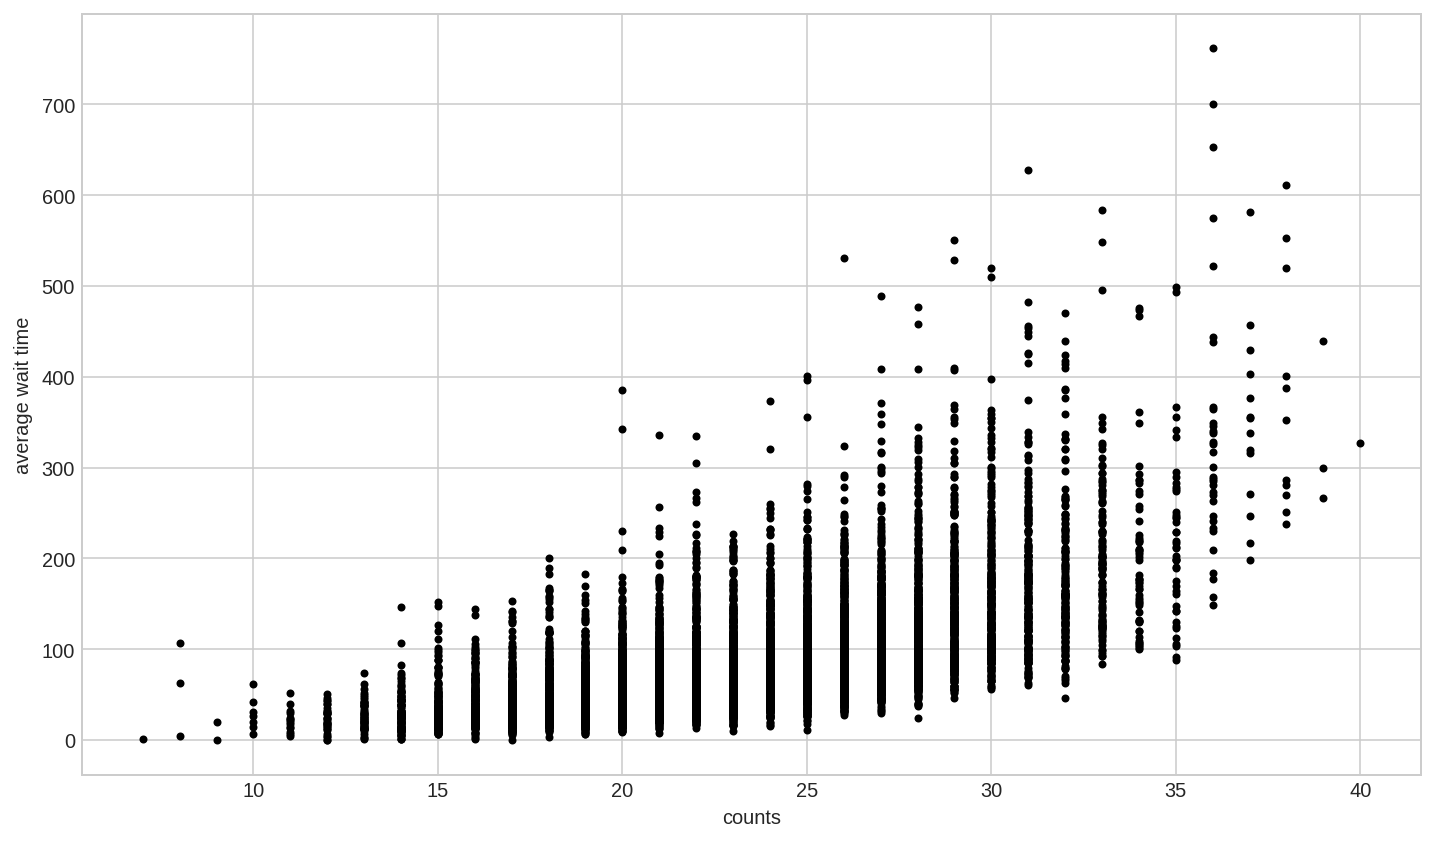

In [10]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.plot(counts, averages, '.', color='black')
plt.xlabel("counts")
plt.ylabel("average wait time");

### Reflection essay (100-200 words, please)

What did you learn during this assignment? How could the assignment have been
better? What would you keep the same about it? And finally, how would you
improve the simulator?

# Put your essay in this cell
What I have learnt from this assignment is how to create a simulation for a case using deque. As for using deque in this simulation, I argue that this is the most optimize solution to write a simulation for a car washing case. If I need to improve the simulator, I would like to have a table for counts and averages then I can compare or sort the data (this is for the real situation in life), or I can have a function to analysis the counts and averages, find out what are the best count and average then I can optimize the car washing time using this simulation.